<a href="https://colab.research.google.com/github/sausis20/Stock-Portfolio-Nasdaq-Baltic/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data and Libraries



In [ ]:
!pip install yfinance

In [ ]:
!pip install --upgrade "kaleido==0.1.*"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
import seaborn as sns
sns.set(style="darkgrid")


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/My Drive/Colab Notebooks/Nasdaq OMX Baltic/data/'

/content/gdrive/My Drive/Colab Notebooks/Nasdaq OMX Baltic/data


# Data Exploration

The data that we collected in the previous step contains a lot of fundamental and other information for each security in the Baltic Main List. 
To get familiar with the data, first let’s visualize the size of the companies in the list, and then take a look at the complete list of features and fundamental data.

## Data visualization for company size

In [ ]:
df_info = pd.read_csv('company_info.csv', index_col=0)
df_tickers = pd.read_csv('tickers.csv', index_col=0)
df_info = df_info.join(df_tickers.set_index('Ticker'))

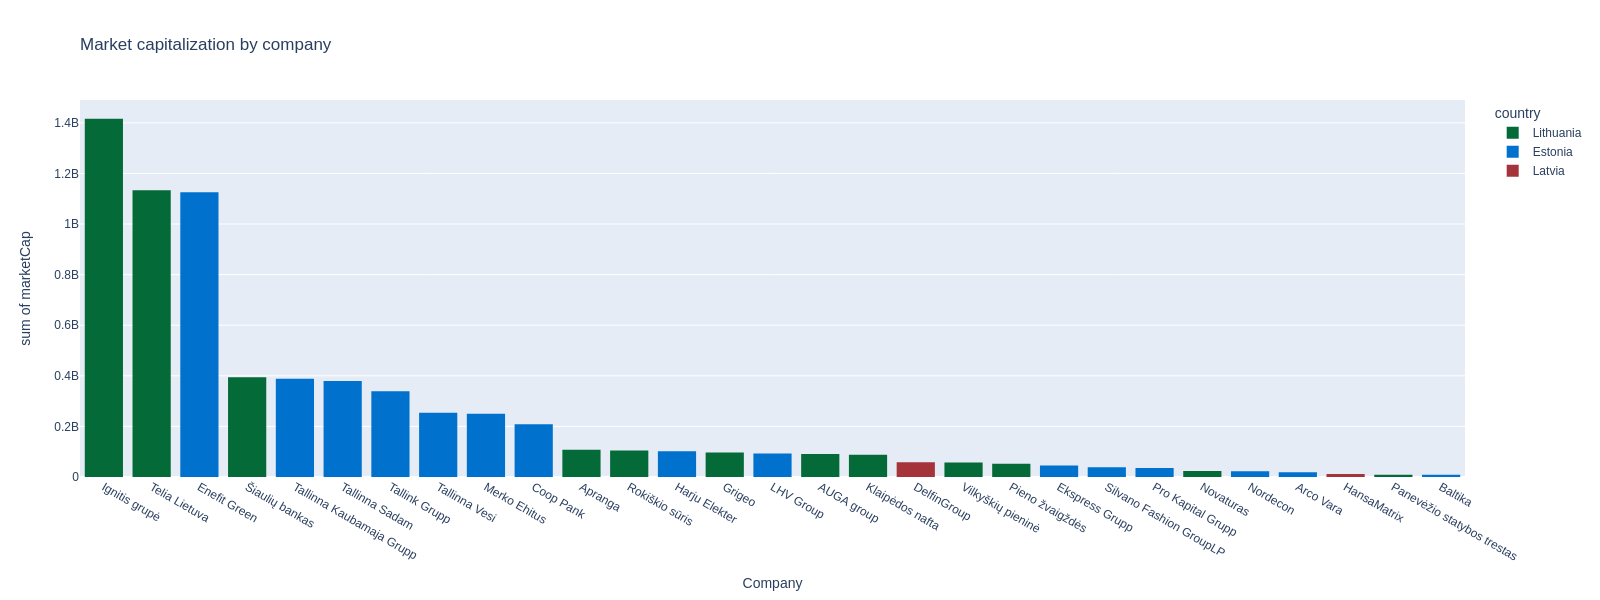

In [ ]:
color_map={'Lithuania': 'rgb(4, 106, 56)', 'Latvia': 'rgb(164,52,58)', 'Estonia': 'rgb(0,114,206)'}
fig = px.histogram(df_info, x='Company', y='marketCap', 
             title="Market capitalization by company", 
             color='country', 
             color_discrete_map=color_map
             ).update_xaxes(categoryorder='total descending')
fig.update_layout(height=600, width=1600)
fig.show('png')

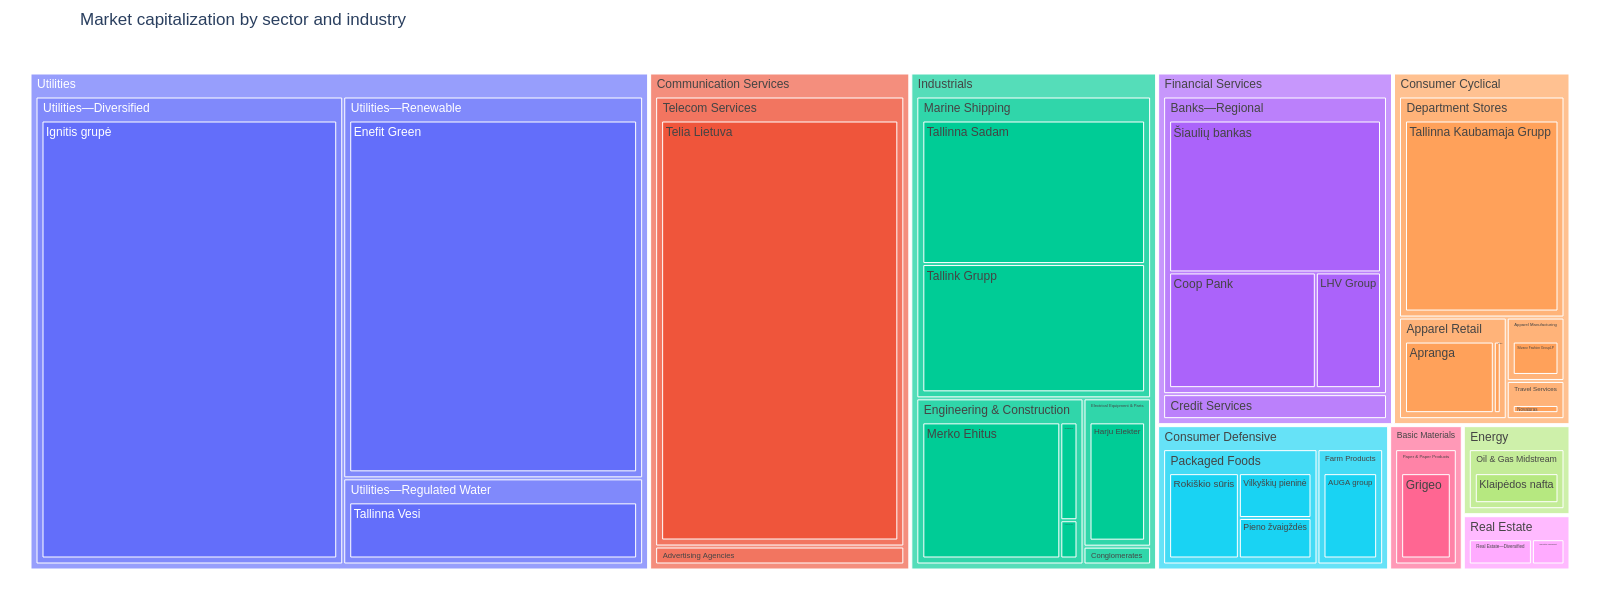

In [ ]:
fig = px.treemap(df_info, path=[px.Constant(""), 'sector', 'industry', 'Company'], values='marketCap', title="Market capitalization by sector and industry")
fig.update_layout(height=600, width=1600, margin = dict(t=50, l=25, r=25, b=25))
fig.show('png')

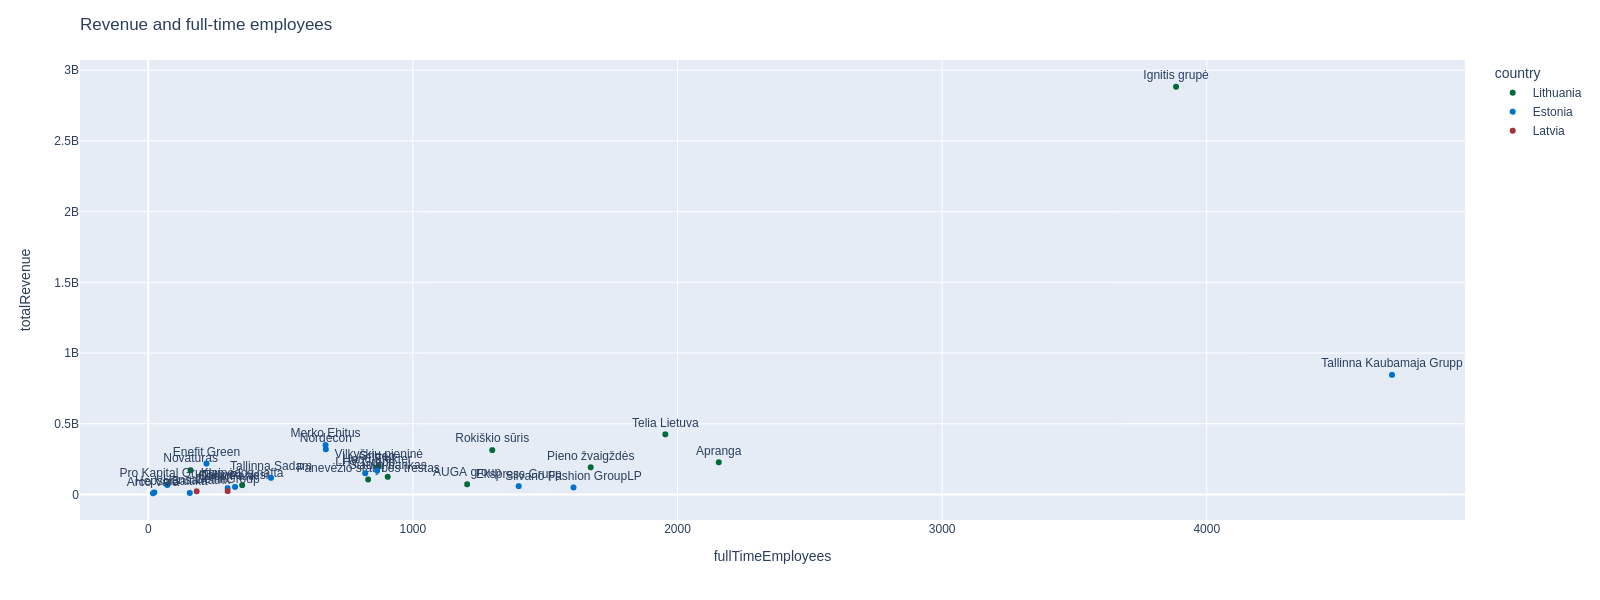

In [ ]:
df_temp = df_info[['totalRevenue', 'fullTimeEmployees', 'country', 'Company']].dropna()
fig = px.scatter(df_temp, x="fullTimeEmployees", y="totalRevenue", 
                 color="country", 
                 text='Company',
                 color_discrete_map=color_map)
fig.update_traces(textposition='top center')
fig.update_layout(height=600, width=1600, title_text='Revenue and full-time employees')
fig.show('png')

We see that the majority of the companies in the Baltic Main List are either Lithuanian or Estonian, with Latvia having only 2 companies out of 30. 
*   The biggest companies bt Market Cap are Ignitis (LT), Telia Lietuva (LT), and Enefit Green (EE) 
*   The industries were the biggest companies operate are Utilities, Communications, Industrials (Marine Shipping), and Financial Services
*   Talinna Kaubamaja Group (EE) has the biggest employee count - 4700, while Ignitis (LT) has the highest revenue (2.88 B eur)

## Features and Fundamental Data

In [ ]:
# Combine Company information, Balance Sheet, Profit & Loss and Cash Flow into one single dataframe. 
# Some columns appear in two dataframes ('Minority Interest' in BS and PL, and 'Net Income' in PL and CF), so we drop the duplicate

df_bs = pd.read_csv('balance_sheet.csv', index_col=0)
df_pl = pd.read_csv('profit_loss.csv', index_col=0)
df_cf = pd.read_csv('cash_flow.csv', index_col=0)
df = df_info.join([df_bs, df_pl.drop('Minority Interest', axis=1), df_cf.drop('Net Income', axis=1)])

# Drop columns doesnt have any information (null values for all companies)

df = df.dropna(how='all', axis=1)
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, APG1L.VS to VLP1L.VS
Data columns (total 182 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    zip                                           30 non-null     int64  
 1    sector                                        30 non-null     object 
 2    fullTimeEmployees                             30 non-null     int64  
 3    longBusinessSummary                           30 non-null     object 
 4    city                                          30 non-null     object 
 5    phone                                         29 non-null     object 
 6    country                                       30 non-null     object 
 7    companyOfficers                               30 non-null     object 
 8    website                                       30 non-null     object 
 9    maxAge                                        

We can see that the combined dataset contain valuable information about, current stock price, items from the financial statements, volume, dividends, various growth rates, price ratios, and even analyst rating information. There are 30 companies in the raw dataset, and a total of 182 columns. Many columns have information for every company (30 non-null values), however, quite a few do not, which means that imputation will be necessary for making use of this dataset. 
We also see that some columns in the dataset contain information about the securities prices - this will be removed at a next step, as we should not have price related information in our explanatory variable list. 
Next, we will get the pricing data with which we can develop the target variables.

## Getting the pricing data

On Nasdaq's Investor Calendar we can see that the companies published their Annual Reports at varying dates, with the last one being Pro Kapital Grupp (PKG1T) who published their report on 2022-05-21. The date of this analysis is 2022-11-30, so we need to get the pricing information over this period of time.

In [ ]:
# Use yfinance to get the pricing data, isolating the Closing prices
start_date = '2022-05-21'
end_date = '2022-11-30'

# Use df's index to pass tickers formatted as a list
tickers = yf.Tickers(list(df.index))
omx_close = tickers.history(start=start_date, end=end_date).Close
omx_close.tail()

[*********************100%***********************]  30 of 30 completed


,APG1L.VS,ARC1T.TL,AUG1L.VS,BLT1T.TL,CPA1T.TL,DGR1R.RG,EEG1T.TL,EGR1T.TL,GRG1L.VS,HAE1T.TL,...,PZV1L.VS,RSU1L.VS,SAB1L.VS,SFG1T.TL,TAL1T.TL,TEL1L.VS,TKM1T.TL,TSM1T.TL,TVE1T.TL,VLP1L.VS
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-23,1.945,1.778328,0.3978,0.159,2.224,1.452,1.495,4.224,0.758,5.77,...,1.140,3.00,0.640,1.0408,0.511,1.950,9.58,1.44,12.70,4.80
2022-11-24,1.935,1.764481,0.3998,0.158,2.214,1.460,1.490,4.224,0.740,5.75,...,1.170,3.00,0.657,1.0450,0.503,1.945,9.56,1.44,12.70,4.80
2022-11-25,1.930,1.748657,0.4018,0.158,2.270,1.462,1.500,4.226,0.734,5.74,...,1.165,3.00,0.650,1.0536,0.498,1.940,9.56,1.44,12.72,4.78
2022-11-28,1.950,1.748657,0.4005,0.156,2.260,1.460,1.495,4.220,0.742,5.64,...,1.120,2.98,0.645,1.0960,0.501,1.950,9.55,1.44,12.70,4.80
2022-11-29,1.950,1.748657,0.4010,0.156,2.292,1.452,1.495,4.288,0.742,5.62,...,1.155,3.00,0.659,1.0940,0.505,1.950,9.54,1.44,12.70,4.81


When conducting this analysis and researching on the topic, it became apparent that it is common practise to use log returns (instead of simple returns) for financial analysis. The benefits of using log prices and log returns rather than raw (i.e. euro) amounts and percent returns is discussed in detail [here](https://quantivity.wordpress.com/2011/02/21/why-log-returns/#:~:text=Benefit%20of%20using%20returns%2C%20versus,price%20series%20of%20unequal%20values.) and [here](https://gregorygundersen.com/blog/2022/02/06/log-returns/). To summarise, the benefits are:

*   they are normally distributed
*   time additivity (the compound return over n periods is the difference in log between initial and final periods, therefore a calculation that is much simpler)
*   approximate raw-log equality (close in value to raw returns)

To calculate the log prices and returns, I first convert the prices to log prices, and then subtract the earliest closing log price from the latest. 

In [ ]:
# Get log prices
log_close = np.log(omx_close)
log_close.to_csv('log_close.csv')

# Create a new dataframe to store our log returns
log_returns = pd.DataFrame(index=log_close.columns, columns=['log_return'])

# Populate new dataframe with log returns for each security
for col in log_close.columns:
    log_return = log_close[col].iloc[-1] - log_close[col].iloc[0]
    log_returns.loc[col, 'log_return'] = log_return
    
log_returns.head()
log_returns.to_csv('log_returns.csv')

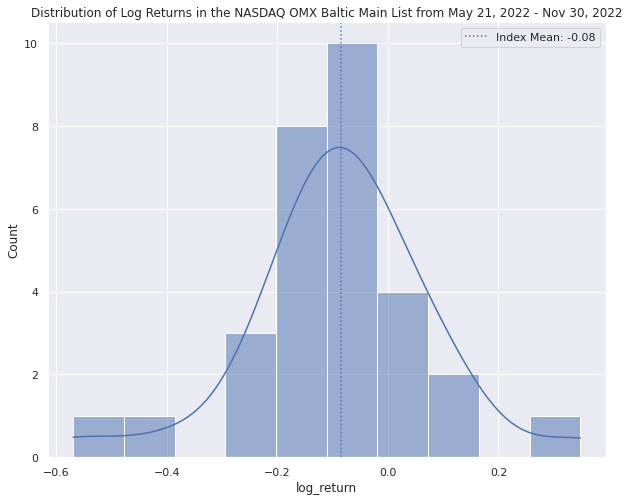

In [ ]:
plt.figure(figsize=(10,8))

sns.histplot(log_returns['log_return'], kde=True)
mean_return = log_returns['log_return'].mean()
plt.title('Distribution of Log Returns in the NASDAQ OMX Baltic Main List from May 21, 2022 - Nov 30, 2022')
plt.axvline(mean_return, ls=':', label='Index Mean: {}'.format(round(mean_return, 2)))
plt.legend();

We can see that the log returns look symmetrical and resembles a normal-shaped distribution, with a mean that is less than zero (-0.08). Translating this result back to raw euro format would be around -8% return, indicating that there was a strong overall downward movement of the market during the time period of study.

Next, we will focus on:
*   dealing with missing data and data imputation
*   modeling the stock price (converted to log) at the date when financial statements were published

In [ ]:
df.to_csv('combined_df.csv')